In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
TRAIN_PATH = "../data/train.pickle"
LABEL_PATH = "../data/label_names.csv"

## Easy

Скачаем сам датасет и названия всех знаков

In [3]:
data = pd.read_pickle(TRAIN_PATH)
label_arr = pd.read_csv(LABEL_PATH)

In [4]:
data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [5]:
unique, count_label = np.unique(data['labels'], return_counts=True)
df_count_label = pd.DataFrame({'label': label_arr.SignName, 'count': count_label})

<Axes: ylabel='count'>

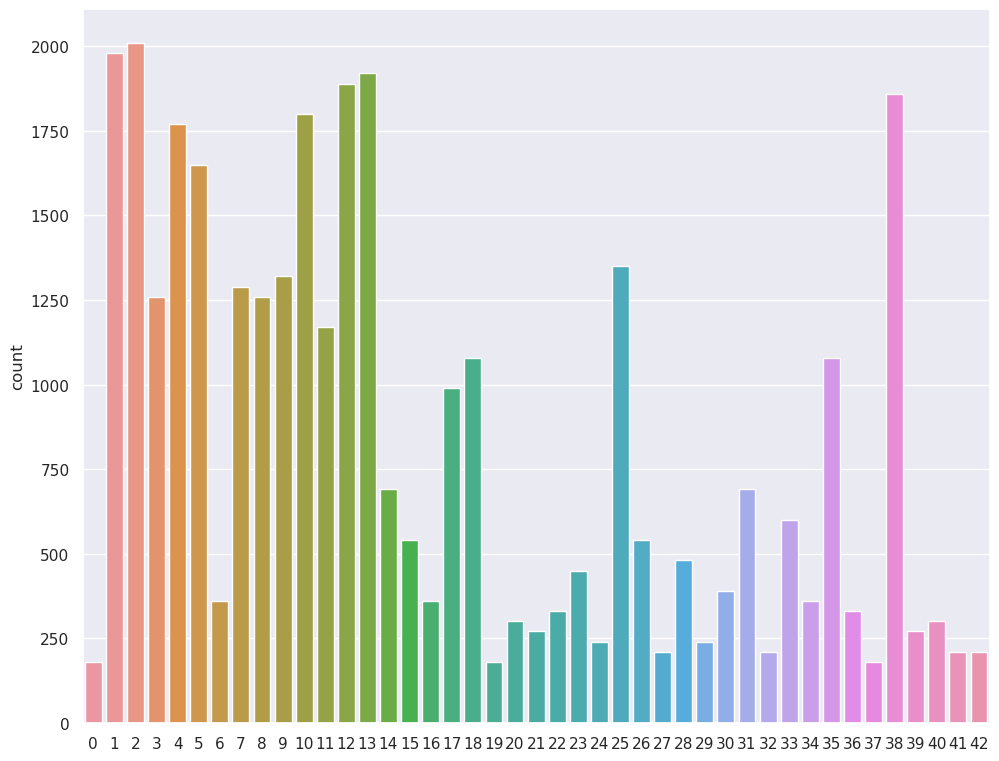

In [6]:
sns.set_theme(rc={'figure.figsize':(11.7,9.27)})
sns.countplot(x=data['labels'], data=pd.DataFrame(data['labels']))

In [7]:
df_count_label[df_count_label['count'] <= 250]

,label,count
0,Speed limit (20km/h),180
19,Dangerous curve to the left,180
24,Road narrows on the right,240
27,Pedestrians,210
29,Bicycles crossing,240
32,End of all speed and passing limits,210
37,Go straight or left,180
41,End of no passing,210
42,End of no passing by vehicles over 3.5 metric ...,210


По графику видно, что данные не распределены равномерно, например, "Speed limit (20km/h)", "Dangerous curve to the left", "Road narrows on the right", "Pedestrians", "Bicycles crossing" и других знаков значительно меньше остальных     

In [8]:
x = list()
y = list()
for i in range(len(data['features'])):
    x.append(data['features'][i].ravel())
    y.append(data['labels'][i])
x = np.array(x)
y = np.array(y)

x = x / 255

In [9]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.33, shuffle=True)

Обучим логистическую регрессию. Сразу посмотрим сразу на accuracy(как часто делается верное предсказание), precision(способность отличать класс от других) и recall(способность распознавать класс). Нужно считать сразу метрики для каждого класса, чтобы выявить, что какой-то класс может угадываться хуже всех

In [10]:
model = LogisticRegression(max_iter=1500)

model.fit(x_train, y_train)
        
y_pred = model.predict(x_test)

log_reg_acc = accuracy_score(y_test, y_pred)
log_reg_precision = precision_score(y_test, y_pred, average=None)
log_reg_recall = recall_score(y_test, y_pred, average=None)

print(f"LogReg accuracy: {log_reg_acc}")
print(f"LogReg precision: {log_reg_precision}")
print(f"LogReg minimal precision: {min(log_reg_precision)}")
print(f"LogReg recall: {log_reg_recall}")
print(f"LogReg minimal recall: {min(log_reg_recall)}")

LogReg accuracy: 0.9498432601880877
LogReg precision: [0.87272727 0.94968553 0.93404908 0.88279302 0.94137931 0.84006734
 0.94067797 0.94117647 0.89425287 0.97794118 0.96612903 0.96231156
 0.99186992 0.97511664 0.99126638 0.92571429 0.96396396 0.98538012
 0.92722372 0.86153846 0.90196078 0.96551724 0.97321429 0.9375
 0.94594595 0.97921478 0.96153846 0.98484848 0.9704142  0.87012987
 0.96116505 0.90748899 0.90140845 0.99069767 0.975      0.98820059
 0.97478992 1.         0.98765432 0.98611111 0.99019608 0.98571429
 0.98630137]
LogReg minimal precision: 0.8400673400673401
LogReg recall: [0.81355932 0.93643411 0.92412747 0.86552567 0.93333333 0.92066421
 0.99107143 0.92753623 0.95577396 0.93882353 0.98036007 0.96962025
 0.99510604 0.97058824 0.99126638 0.92045455 0.97272727 0.99117647
 0.98285714 0.91803279 0.91089109 0.96551724 0.98198198 0.91603053
 0.86419753 0.96145125 0.86705202 0.89041096 0.97619048 0.82716049
 0.91666667 0.93636364 0.90140845 0.98611111 0.96694215 0.98529412
 0.966

Видно, что accuracy несильно отличается от большей части precision и recall, значит, модель довольно точно определяет классы

Посмотрим на то, как модель угадала каждый из знаков, будем использовать метрику F-меру, т.к. это среднее гармоническое recall и precision

In [11]:
most_unrecognizable = None
most_unrecognizable_score = 1
less_than_09 = []
for i in range(len(label_arr)):
    score = f1_score(y_test, y_pred, labels=[i], average=None)
    print(f"{label_arr.iloc[i]['SignName']}: {score}")
    if score < 0.9:
        less_than_09.append((score, label_arr.iloc[i]['SignName']))
    if score < most_unrecognizable_score:
        most_unrecognizable_score = score
        most_unrecognizable = label_arr.iloc[i]['SignName']

Speed limit (20km/h): [0.84210526]
Speed limit (30km/h): [0.94301327]
Speed limit (50km/h): [0.92906178]
Speed limit (60km/h): [0.87407407]
Speed limit (70km/h): [0.93733906]
Speed limit (80km/h): [0.87852113]
End of speed limit (80km/h): [0.96521739]
Speed limit (100km/h): [0.93430657]
Speed limit (120km/h): [0.9239905]
No passing: [0.95798319]
No passing for vehicles over 3.5 metric tons: [0.97319253]
Right-of-way at the next intersection: [0.96595208]
Priority road: [0.99348534]
Yield: [0.97284717]
Stop: [0.99126638]
No vehicles: [0.92307692]
Vehicles over 3.5 metric tons prohibited: [0.96832579]
No entry: [0.98826979]
General caution: [0.95423024]
Dangerous curve to the left: [0.88888889]
Dangerous curve to the right: [0.90640394]
Double curve: [0.96551724]
Bumpy road: [0.97757848]
Slippery road: [0.92664093]
Road narrows on the right: [0.90322581]
Road work: [0.97025172]
Traffic signals: [0.9118541]
Pedestrians: [0.9352518]
Children crossing: [0.97329377]
Bicycles crossing: [0.848

In [12]:
less_than_09

[(array([0.84210526]), 'Speed limit (20km/h)'),
 (array([0.87407407]), 'Speed limit (60km/h)'),
 (array([0.87852113]), 'Speed limit (80km/h)'),
 (array([0.88888889]), 'Dangerous curve to the left'),
 (array([0.84810127]), 'Bicycles crossing')]

In [13]:
print(f"Most Unrecognizable - {most_unrecognizable}: {most_unrecognizable_score}")

Most Unrecognizable - Speed limit (20km/h): [0.84210526]


Хуже всего угадывает "Bicycles crossing", а также "Speed limit (20km/h)"/(60km/h)/(80km/h)  

## Medium

In [14]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns

In [15]:
svc_acc = []
svc_precision = []
svc_recall = []

for kernel in ['linear', 'poly', 'rbf']:
    model_svc = SVC(kernel=kernel, max_iter=400, degree=2)
    
    model_svc.fit(x_train, y_train)
    
    y_pred = model_svc.predict(x_test)
    
    ker_svc_acc = accuracy_score(y_test, y_pred)
    ker_svc_precision = precision_score(y_test, y_pred, average=None)
    ker_svc_recall = recall_score(y_test, y_pred, average=None)
    
    svc_acc.append(ker_svc_acc)
    svc_precision.append(ker_svc_precision)
    svc_recall.append(ker_svc_recall)
    
    print(f'{kernel} accuracy: {ker_svc_acc}')
    print(f'{kernel} precicision: {ker_svc_precision}')
    print(f'{kernel} minimal precicision: {min(ker_svc_precision)}')
    print(f'{kernel} recall: {ker_svc_recall}')
    print(f'{kernel} minimal recall: {min(ker_svc_recall)}')

linear accuracy: 0.9181469871125043
linear precicision: [0.7761194  0.82798834 0.85618729 0.82878412 0.94507576 0.77896613
 0.94915254 0.73833671 0.89260143 0.94964029 0.98489933 0.92537313
 0.99834437 0.97347894 0.97402597 0.93181818 0.94782609 0.98511905
 0.90080429 0.88888889 0.89622642 0.87755102 0.97368421 0.87218045
 0.89285714 0.98771499 0.96052632 0.94366197 0.9625     0.81052632
 0.87962963 0.93087558 0.87341772 0.99526066 0.98360656 0.95918367
 0.89312977 0.98484848 0.99368088 1.         0.97196262 1.
 1.        ]
linear minimal precicision: 0.7383367139959433
linear recall: [0.88135593 0.88062016 0.77693475 0.81662592 0.85299145 0.80627306
 1.         0.87922705 0.91891892 0.93176471 0.96072013 0.94177215
 0.98368679 0.96594427 0.98253275 0.93181818 0.99090909 0.97352941
 0.96       0.91803279 0.94059406 0.98850575 1.         0.88549618
 0.92592593 0.91156463 0.84393064 0.91780822 0.91666667 0.95061728
 0.87962963 0.91818182 0.97183099 0.97222222 0.99173554 0.96764706
 0.975

Хуже всех работает полиномиальное ядро, т.к. оно очень чувствительно к переобучению, особенно при больших степенях. Аналогично для rbf, оно так же могло переобучиться

Выберем гиперпараметр для KNN

In [16]:
neib = []
k_n = 0
max_score = 0
for k in range(3, 12):
    model = KNeighborsClassifier(n_neighbors=k)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    neib.append((score, k))
    if max_score < score:
        max_score = score
        k_n = k
print(f"knn core: {max_score}")

knn core: 0.8862765586903518


In [17]:
print(k_n)

3


<Axes: xlabel='k', ylabel='score'>

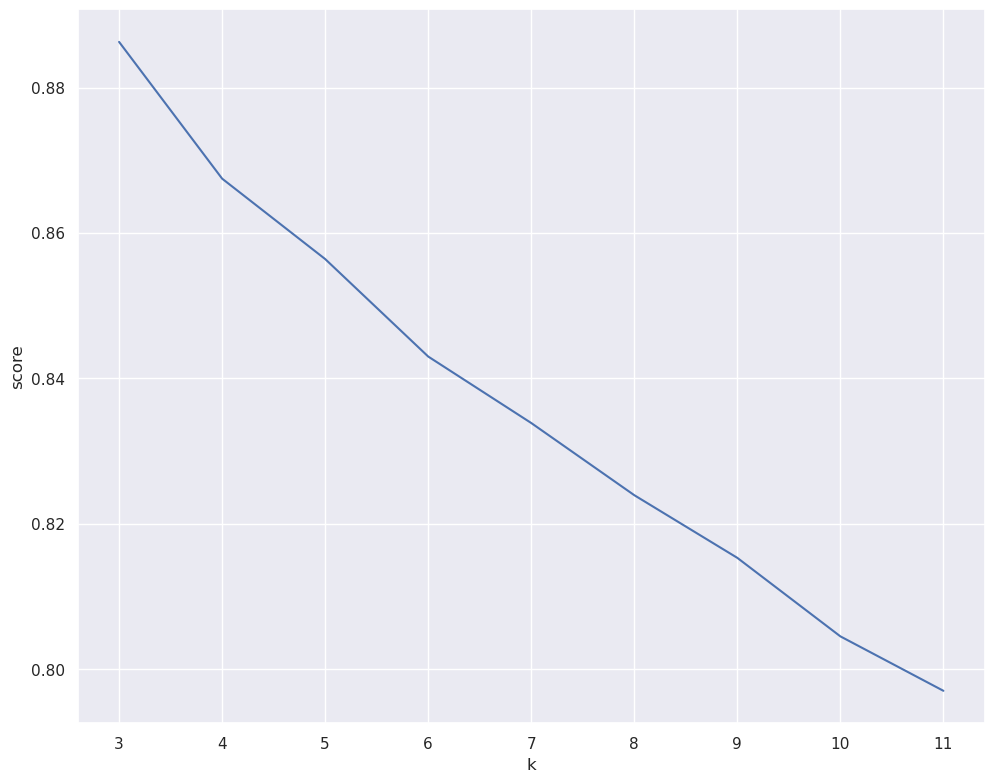

In [18]:
df = pd.DataFrame(np.array(neib), columns=['score', 'k'])
sns.lineplot(df, x='k', y='score')

In [19]:
model = KNeighborsClassifier(n_neighbors=k_n)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

knn_acc = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average=None)
knn_recall = recall_score(y_test, y_pred, average=None)

print(f"KNN accuracy: {knn_acc}")
print(f"KNN precision: {knn_precision}")
print(f"KNN minimal precision: {min(knn_precision)}")
print(f"KNN recall: {knn_recall}")
print(f"KNN minimal recall: {min(knn_recall)}")

KNN accuracy: 0.8862765586903518
KNN precision: [0.8030303  0.84822695 0.82676056 0.74943052 0.80515298 0.73520249
 0.88333333 0.76826722 0.84597701 0.94074074 0.91385135 0.90659341
 0.9737303  0.96496815 0.98514851 0.95973154 0.92307692 0.98095238
 0.88795518 0.86885246 0.82857143 0.91111111 0.88888889 0.9609375
 0.95238095 0.93450882 0.89534884 0.89552239 0.97350993 0.93150685
 0.87272727 0.8266129  0.87142857 0.97979798 0.96460177 0.93968254
 0.97247706 0.95238095 0.94417077 0.98611111 0.91752577 0.95522388
 1.        ]
KNN minimal precision: 0.735202492211838
KNN recall: [0.89830508 0.92713178 0.89074355 0.80440098 0.85470085 0.87084871
 0.94642857 0.88888889 0.9041769  0.89647059 0.88543372 0.83544304
 0.90701468 0.9380805  0.86899563 0.8125     0.98181818 0.90882353
 0.90571429 0.86885246 0.86138614 0.94252874 0.93693694 0.9389313
 0.74074074 0.84126984 0.89017341 0.82191781 0.875      0.83950617
 0.88888889 0.93181818 0.85915493 0.89814815 0.90082645 0.87058824
 0.88333333 0.923

KNN даёт довольно неплохую точность, несмотря на большое количество фич, однако всё ещё хуже логической регрессии

In [20]:
model = MultinomialNB()

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

nbc_acc = accuracy_score(y_test, y_pred)
nbc_precision = precision_score(y_test, y_pred, average=None)
nbc_recall = recall_score(y_test, y_pred, average=None)

print(f"MultinomialNB accuracy: {nbc_acc}")
print(f"MultinomialNB precision: {nbc_precision}")
print(f"MultinomialNB minimal precision: {min(nbc_precision)}")
print(f"MultinomialNB recall: {nbc_recall}")
print(f"MultinomialNB minimal recall: {min(nbc_recall)}")

MultinomialNB accuracy: 0.34796238244514105
MultinomialNB precision: [0.08641975 0.37751004 0.2419128  0.10043988 0.19079346 0.16370107
 0.69014085 0.27428571 0.09933775 0.59375    0.6730038  0.80116959
 0.91935484 0.92156863 0.6712963  0.33333333 0.43939394 0.88931298
 0.53005464 0.23333333 0.         0.1712963  0.76666667 0.21153846
 0.52380952 0.56704981 0.51578947 0.09433962 0.5890411  0.06329114
 0.18108108 0.19953052 0.13541667 0.82       0.19459459 0.76494024
 0.98571429 0.78571429 0.73622047 0.32335329 0.39772727 0.10730594
 0.66666667]
MultinomialNB minimal precision: 0.0
MultinomialNB recall: [0.3559322  0.14573643 0.26100152 0.33496333 0.53846154 0.08487085
 0.4375     0.11594203 0.03685504 0.35764706 0.28968903 0.34683544
 0.37194127 0.50928793 0.63318777 0.13068182 0.26363636 0.68529412
 0.27714286 0.3442623  0.         0.42528736 0.20720721 0.08396947
 0.13580247 0.33560091 0.28323699 0.68493151 0.25595238 0.12345679
 0.62037037 0.38636364 0.18309859 0.37962963 0.59504132

НБК показывает худший результат, т.к. чтобы его использовать, мы предполагаем, что признаки - независимы, однако это не так. Очевидно, что пиксели на картинках как-то зависят друг от друга.

## Hard (TODO)

In [21]:
import sys
sys.path.insert(1, '../data')

import datasets_preparing

Будем поэтапно удалять данные из датасета и компенсировать их обработанными оставшимися картинками 

In [22]:
x = list()
y = list()
for i in range(len(data['features'])):
    x.append(data['features'][i])
    y.append(data['labels'][i])
y = np.array(y)

score = log_reg_acc
prec, rec = log_reg_precision, log_reg_recall
score_ = log_reg_acc
prec_, rec_ = log_reg_precision, log_reg_recall
min_l = len(y)
acc_arr = [log_reg_acc]
dataset_size = [min_l]
x_copy = pd.Series(x)
y_copy = pd.Series(y)
while score > 0.85:
    score = score_
    prec = prec_
    rec = rec_
    l = len(y_copy)
    
    for i in range(0, len(label_arr)):
        index2remove = y_copy.loc[(y_copy == i) & (len(y_copy[y_copy == i]) / len(y_copy) >= 1 / len(label_arr))].index[:len(y_copy[y_copy == i]) // 4]
        y_copy = y_copy.drop(index2remove)
        x_copy = x_copy.drop(index2remove)
        y_copy.reset_index()
        x_copy.reset_index()
        
    if l == len(y_copy):
        min_l = l
        break
        
    x_train, x_test, y_train, y_test = train_test_split(np.array([*x_copy.array]), y_copy, test_size=0.33, shuffle=True, stratify=y_copy)
    x_train, y_train = datasets_preparing.equalize_training_dataset(x_train, y_train)
    model = LogisticRegression(max_iter=400)
    
    x_train_correct = list()
    for i in range(len(x_train)):
        x_train_correct.append(x_train[i].ravel())
    x_test_correct = list()
    for i in range(len(x_test)):
        x_test_correct.append(x_test[i].ravel())
    
    model.fit(np.array(x_train_correct), y_train)
    
    y_pred = model.predict(np.array(x_test_correct))
    score_ = accuracy_score(y_test, y_pred)
    prec_ = precision_score(y_test, y_pred, average=None)
    rec_ = recall_score(y_test, y_pred, average=None)
    acc_arr.append(score_)
    dataset_size.append(l)
    if (min(rec_) < 0.73) or (min(prec_) < 0.73) or (score_ < 0.85):
        min_l = l
        break

100%|██████████| 43/43 [00:00<00:00, 73.14it/s]


<Axes: xlabel='dataset_size', ylabel='accuracy'>

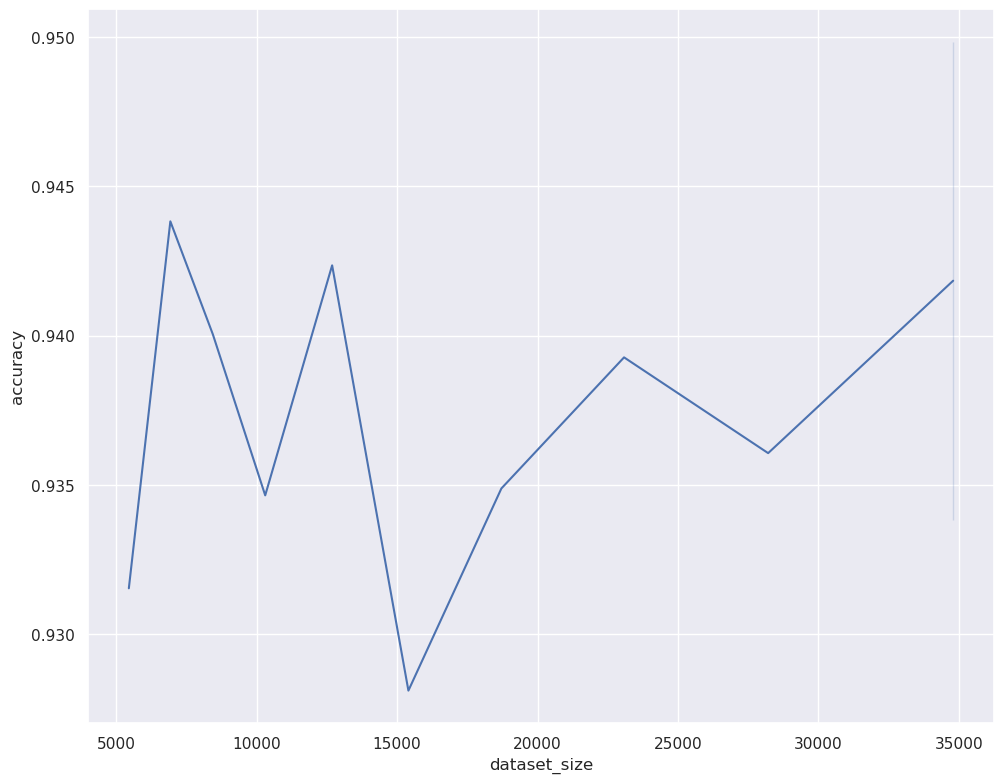

In [23]:
df_acc_size = pd.DataFrame({"accuracy": np.array(acc_arr), "dataset_size": np.array(dataset_size)})
sns.lineplot(df_acc_size, x="dataset_size", y="accuracy")

In [24]:
print(f"Size of dataset before: {len(y)}")
print(f"Size of dataset after: {min_l}")
print(f"Accuracy before: {log_reg_acc}")
print(f"Accuracy after: {score}")
print(f"Minimal precision before: {min(log_reg_precision)}")
print(f"Minimal precision after: {min(prec)}")
print(f"Minimal recall before: {min(log_reg_recall)}")
print(f"Minimal recall after: {min(rec)}")

Size of dataset before: 34799
Size of dataset after: 5446
Accuracy before: 0.9498432601880877
Accuracy after: 0.9438264738598443
Minimal precision before: 0.8400673400673401
Minimal precision after: 0.8260869565217391
Minimal recall before: 0.8135593220338984
Minimal recall after: 0.813953488372093


In [25]:
print(f"Precision after: {prec}")
print(f"Recall after: {rec}")

Precision after: [0.97826087 0.9787234  0.88679245 0.82608696 0.88372093 0.87804878
 0.94339623 0.90697674 0.91111111 0.95555556 0.95744681 0.88095238
 1.         0.9787234  1.         0.94594595 1.         1.
 0.89189189 0.93478261 0.9047619  0.97435897 1.         0.92105263
 1.         1.         0.95       0.86046512 0.92307692 0.90909091
 1.         0.95       0.85       1.         0.97297297 0.97297297
 1.         1.         0.92       1.         1.         0.94117647
 0.85      ]
Recall after: [1.         0.93877551 0.94       0.9047619  0.86363636 0.85714286
 1.         0.90697674 0.97619048 0.97727273 1.         0.94871795
 0.9787234  0.95833333 0.95121951 0.81395349 1.         1.
 0.91666667 0.95555556 0.9047619  1.         0.97826087 0.97222222
 0.88888889 0.95555556 0.88372093 0.94871795 0.94736842 0.88888889
 0.95121951 0.92682927 0.87179487 1.         0.94736842 1.
 0.97142857 1.         1.         1.         0.97619048 0.82051282
 0.87179487]


Получилось существенно уменьшить размер датасета